In [387]:
import pymc3 as pm 
import numpy as np 
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd 
import os 

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 17}

plt.rc('font', **font)


# Sum of Squares Likelihood

In [388]:
import theano 
import pymc3 as pm
from scipy import stats
from theano import shared, tensor as tt
from pymc3.distributions import draw_values
from pymc3.distributions import generate_samples
from pymc3.theanof import floatX
from pymc3.distributions.dist_math import bound
from pymc3.distributions import (Continuous, draw_values, generate_samples)

def assert_negative_support(var, label, distname, value=-1e-6):
    # Checks for evidence of positive support for a variable
    if var is None:
        return
    try:
        # Transformed distribution
        support = np.isfinite(var.transformed.distribution.dist
                              .logp(value).tag.test_value)
    except AttributeError:
        try:
            # Untransformed distribution
            support = np.isfinite(var.distribution.logp(value).tag.test_value)
        except AttributeError:
            # Otherwise no direct evidence of non-positive support
            support = False
    if np.any(support):
        msg = "The variable specified for {0} has negative support for {1}, ".format(
            label, distname)
        msg += "likely making it unsuitable for this parameter."
        warnings.warn(msg)
def get_tau_sigma(tau=None, sigma=None):
    if tau is None:
        if sigma is None:
            sigma = 1.
            tau = 1.
        else:
            tau = sigma**-2.

    else:
        if sigma is not None:
            raise ValueError("Can't pass both tau and sigma")
        else:
            sigma = tau**-.5
    # cast tau and sigma to float in a way that works for both np.arrays
    # and pure python
    tau = 1. * tau
    sigma = 1. * sigma
    return floatX(tau), floatX(sigma)
class Sum_of_Squares(pm.distributions.Continuous):
    
    def __init__(self, mu=0, sigma=None, tau=None, sd=None, **kwargs):
        if sd is not None:
            sigma = sd
        tau, sigma = get_tau_sigma(tau=tau, sigma=sigma)
        self.sigma = self.sd = tt.as_tensor_variable(sigma)
        self.tau = tt.as_tensor_variable(tau)
        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
        self.variance = 1. / self.tau
        assert_negative_support(sigma, 'sigma', 'Normal')
        assert_negative_support(tau, 'tau', 'Normal')
        super().__init__(**kwargs)
        
    def random(self, point=None, size=None):
        
        mu, tau, _ = draw_values([self.mu, self.tau, self.sigma],
                                 point=point, size=size)
        return generate_samples(stats.norm.rvs, loc=mu, scale=tau**-0.5,
                                dist_shape=self.shape,
                                size=size)
    def logp(self, value):
        """
        Sum of Squares
        
        """
        sigma = self.sigma
        tau = self.tau
        mu = self.mu
        
        logp = - tt.sqr(value - mu)/(2.0 * sigma *sigma)
        return logp.sum()

In [389]:
cwd = os.chdir("/Users/jackcarter/Downloads")
df6 = pd.read_csv("Kula_Biotite_3_data.csv",
                  engine = 'python')
df6.dropna(axis =0, how = 'all')

temp1 = df6['Temp'].values
time1 = df6['Time'].values
a391 = df6['39Ar'].values
a401 = df6['40Ar'].values
age1 = df6['Age'].values
age1_err = df6['Age_Err'].values

In [390]:
# Shared variable for modelling 
from theano import shared, tensor as tt
data = age1
err = age1_err

age_err = shared(err*3)

In [391]:
def Increment(ea, d0, a, temp, t):
    R = 8.314e-3
    
    D0t = (d0/(a**2))*np.exp(-ea/(R*temp))*t
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    aa1 = np.sqrt(np.pi) * R * temp**2
    bb1 = d0*np.exp(-ea/(R*temp))*t
    z1 = (3*ea *np.sqrt(bb1/a**2))/aa1
    

    aa2 = np.sqrt(np.pi) * R *temp**2
    bb2 = d0*np.exp(-ea/(R*temp))*t
    z2 = (3*ea*(np.sqrt(bb2/a**2) - np.sqrt(np.pi)*bb2/a**2))/aa2
      
    
    aa3 = a**2 * R * temp**2
    bb3 = d0*np.exp(-ea/(R*temp))*t
    z3 = 6 * d0 * ea * t * np.exp((-np.pi**2 * bb3/a**2) - ea/(R*temp))/aa3

    
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    
    T = tt.switch(q < 0.1, z1, Q)
    
    
    return T

In [392]:
def fracrelx(Ea, D0, a, temp, time): 
    R = 8.314e-3
    D0t = (D0/(a**2))*np.exp(-Ea/(R*temp))*time
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    q1 = (6./(np.pi**(1.5)))*np.sqrt((np.pi**2)*D0t)
    
    q2 = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)\
    - (3./(np.pi**2)) *((np.pi**2)* D0t)
    
    q3 = 1 - (6./(np.pi**2)) *np.exp(-(np.pi**2)*D0t)
     
    
    
    Q = tt.switch(q <= 0.9, q2, q3)
    T = tt.switch(q < 0.1, q, Q)
    
    return T

In [393]:
def frel_data(x): 
    y = np.cumsum(x) 
    dd = y/y.max()
    return dd

In [394]:
x = 100 *frel_data(a391)

# The Age Spectra

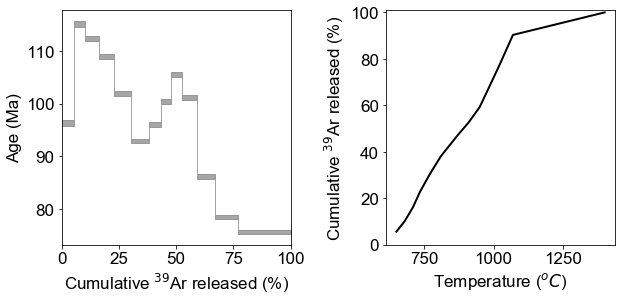

In [395]:
y = np.insert(x, 0, 0)
age_plot = np.insert(data, 0, data[0])
age_plot_err = np.insert(err, 0, err[0])


fig, ax = plt.subplots(1,2, figsize = (9, 4.5))

ax[0].fill_between(y, age_plot - age_plot_err, age_plot + age_plot_err, 
                  step = 'pre', 
                  color = 'grey', alpha = 0.7, 
                  edgecolor = 'k')
ax[0].set_xlim(y.min(), y.max())

ax[0].set_ylabel('Age (Ma)')
ax[0].set_xlabel('Cumulative $^{39}$Ar released (%)')

ax[1].plot(temp1,x, lw = 2, 
          color= 'k')
ax[1].set_ylabel('Cumulative $^{39}$Ar released (%)')
ax[1].set_xlabel('Temperature ($^{o}C$)')
ax[1].set_ylim(0, 101)
plt.tight_layout()

In [396]:
data_f = x/100
tempk = temp1 + 273.15
t_obs = time1 * 60
N = data.shape[0]
R = 8.314e-3

age_error_for_model = shared(err*2)

In [397]:
Q = pm.Model()

with Q: 
    
    # Mixing Fraction for each 
    phi = pm.Dirichlet('phi', 
                      a = np.array([0.25,0.75]), 
                      shape = 2, 
                       testval = (0.25, 0.75))
    
    # Assign a mixing fraction to each component
    w1 = phi[0]
    w2 = phi[1]
    
    # Potential Bounds for the mixing fraction 
    w1_potential = pm.Potential('p1_con', 
                               tt.switch(w1 < 0.2, 
                                        -np.inf, 0) + 
                               tt.switch(w1 > 0.3, 
                                        -np.inf, 0))
    
    # Diffusion kinetics 
########################################################  
########################################################
    
    # Activation Energy
    ea1 = pm.Normal('ea1', mu = 196,
                    sd = 2, 
                   testval = 196)
    ea2 = pm.Normal('ea2', mu = 196,
                    sd = 2, 
                   testval = 196)
    
    
    # Frequency Factor
    d01 = pm.Lognormal('d01', mu = 0.002,
                       sd = 0.1)
    
    d02 = pm.Lognormal('d02', mu = 0.002,
                      sd = 0.1)
    
########################################################
########################################################
    
    # Grain sizes
    a1 = pm.Uniform('a1', lower = 0.0177/2, 
                   upper= 0.025/2)
    
    a2 = pm.Uniform('a2', lower = 0.0177/2, 
                   upper= 0.025/2)

In [398]:
with Q: 
    # Age of each component 
    
    age1 = pm.Uniform('age1', lower = 0.0, upper = 4600, 
                     testval = 200)
    
    age2 = pm.Uniform('age2', lower = 0.0, upper = 4600, 
                     testval = 100)
    
    age_cons = pm.Potential('age_con', 
                           tt.switch(age1 - age2 < 0, 
                                    -np.inf, 0))

In [399]:
with Q: 
    # Multi-component age model
    
    X = Increment(ea1, d01, a1, tempk, t_obs)
    Y = Increment(ea2, d02, a2, tempk, t_obs)

    
    mu2 = ((w1*X)/(w1*X + w2*Y))*age1 +\
    ((w2*Y)/(w1*X + w2*Y))*age2   

    model2 = pm.Deterministic('model2', mu2)

In [400]:
with Q: 
    # Cumulative Release Model 

    A = fracrelx(ea1, d01, a1, tempk, t_obs)
    B = fracrelx(ea2, d02, a2, tempk, t_obs)
    
    # Individual Cumulative Release
    AA = pm.Deterministic('AA', A)
    BB = pm.Deterministic('BB', B)
    
    mu1 = w1*A + w2*B

    # MONOTONIC Constraint
######################################################################
    for i in range(len(tempk) -1): 
        F_con1 = pm.Potential(f'F_con1{i}', 
                             tt.switch(A[i + 1] - A[i] <0, 
                                      -np.inf, 0) + 
                             tt.switch(B[i +1] - B[i] < 0, 
                                      -np.inf, 0))

    for i in range(len(tempk) -1): 
        F_con2 = pm.Potential(f'F_con2{i}', 
                             tt.switch(mu1[i + 1] - mu1[i] <0, 
                                      -np.inf, 0))
        
    # Constraint to the fractional release model 
    frac_rel_cons = pm.Potential('frac_rel_cons', 
                                tt.switch(mu1 >1, -np.inf, 0))
######################################################################    

    
    # Fractional Release Equation 
    f_err1 = pm.HalfNormal('f_err1', 
                           sd = 0.01, 
                          shape = N)

In [401]:
# Models for plotting 
with Q: 
    f_model = pm.Deterministic('f_model', 
                               mu1)
    age_model = pm.Deterministic('Age_Model', 
                                mu2)

In [402]:
with Q: 
    age_model_error = pm.HalfNormal('age_model_error', 
                                   sd = 5, 
                                   shape = N)

In [403]:
with Q: 
    # Cumulative Release Likelihood 
    L1 = pm.Normal('L1', mu = mu1, 
                   sd = f_err1, 
                   observed = data_f)
    
    # Age spectra likelihood
    L2 = Sum_of_Squares('L2', mu2, 
                        age_error_for_model, 
                        observed = data)


# Check Test Value for logp

In [404]:
Q.check_test_point()

L1                       -2135.48
L2                      -10617.17
a1_interval__               -1.39
a2_interval__               -1.39
age1_interval__             -3.18
age2_interval__             -3.85
age_model_error_log__      -10.78
d01_log__                    1.38
d02_log__                    1.38
ea1                         -1.61
ea2                         -1.61
f_err1_log__               -10.78
phi_stickbreaking__         -2.05
Name: Log-probability of test_point, dtype: float64

In [ ]:
SAMPLES = 52000
BURN = 100000
with Q: 
    
    step1 = pm.NUTS([phi], target_accept = 0.90)
    
    step2 = pm.Metropolis([ea1, 
                           ea2, 
                           age1, age2,
                           a1, a2,
                           f_err1, 
                          d01, d02])

    
    trace = pm.sample(SAMPLES, tune = BURN, 
                     step = [step1, step2])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [phi]
>CompoundStep
>>Metropolis: [d02]
>>Metropolis: [d01]
>>Metropolis: [f_err1]
>>Metropolis: [a2]
>>Metropolis: [a1]
>>Metropolis: [age2]
>>Metropolis: [age1]
>>Metropolis: [ea2]
>>Metropolis: [ea1]
>NUTS: [age_model_error]
Sampling 2 chains:  39%|███▉      | 118572/304000 [2:15:18<40:34, 76.18draws/s]     

# Traceplot

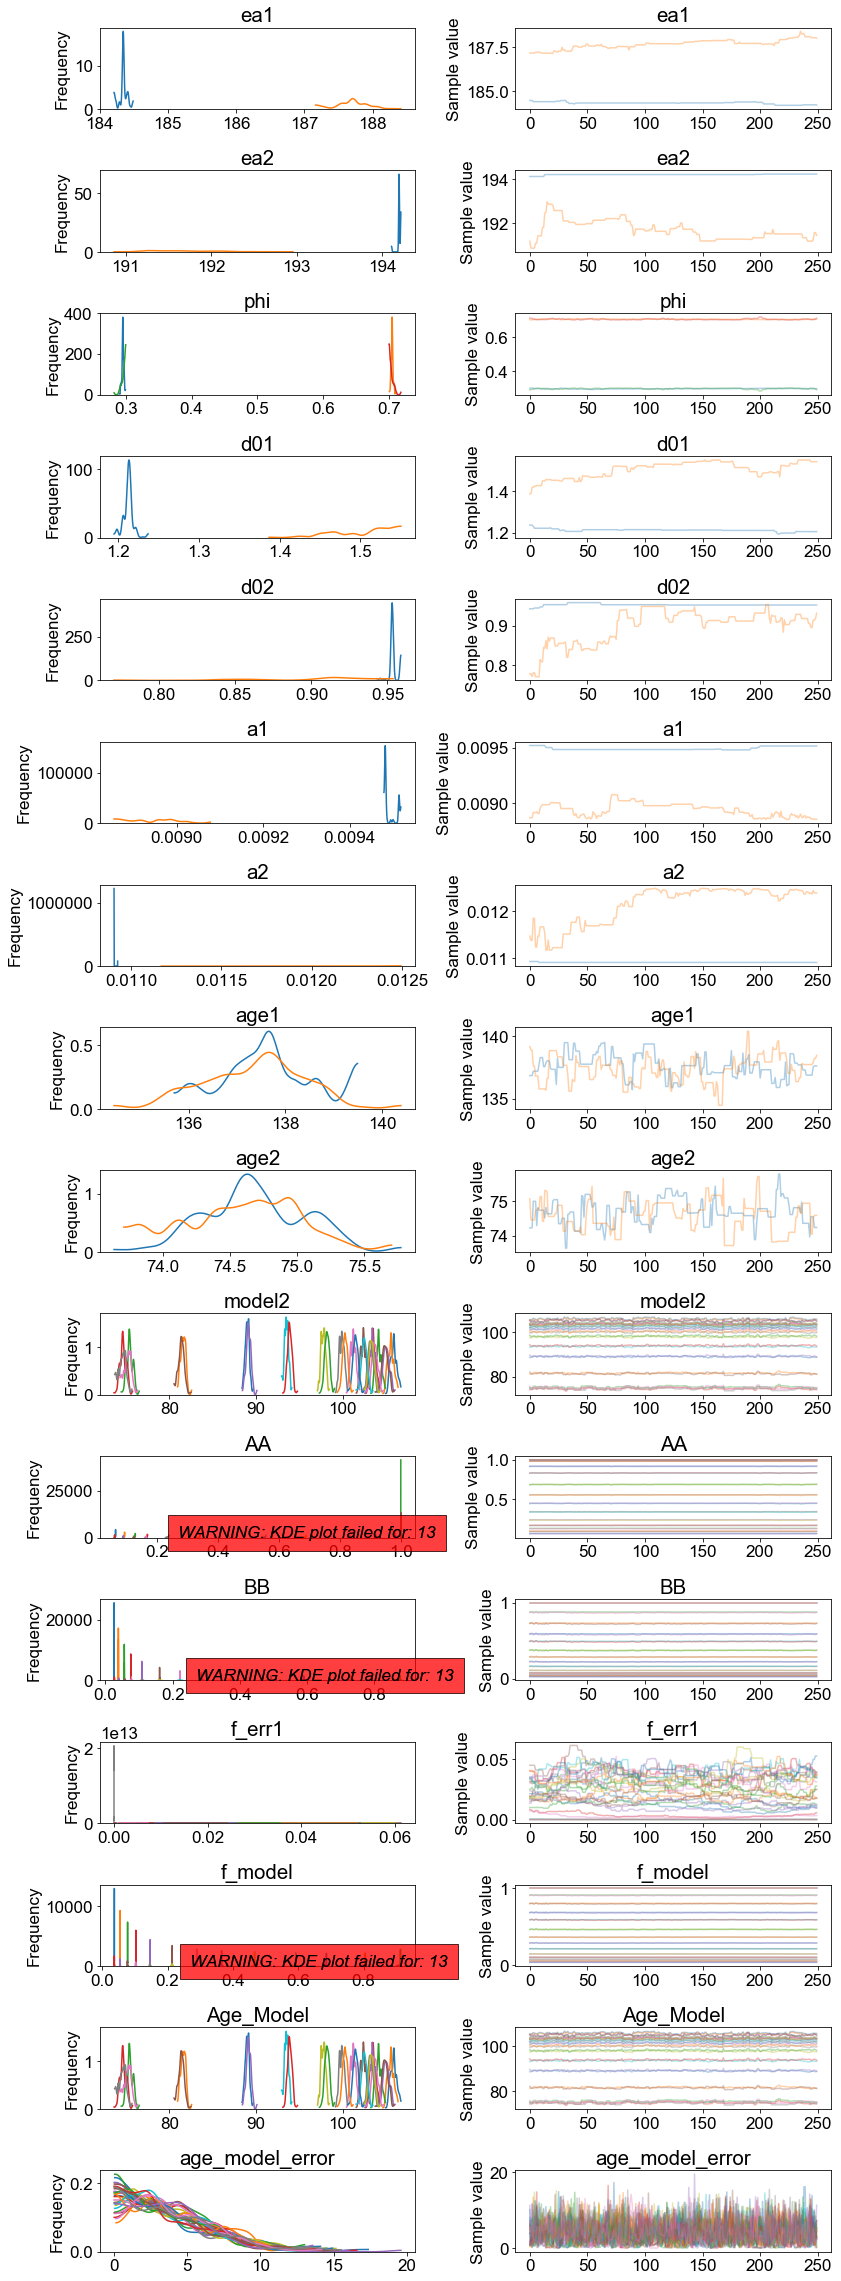

In [384]:
pm.traceplot(trace[-250:]); 

# Post Posterior Predictions


In [385]:
with Q: 
    ppc = pm.sample_ppc(trace, 10000)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 10000/10000 [01:57<00:00, 85.31it/s]


# Posterior Predictive model and 95% Credible Intervals

In [386]:
x1 = ppc['L1'].mean(axis = 0)
x2 = ppc['L2'].mean(axis = 0)

# 95% Credible model intervals 
low_age, high_age = np.percentile(trace['Age_Model'][-SAMPLES::2],
                                  [2.5, 97.5], 
                                  axis=0)
low_f, high_f = np.percentile(trace['f_model'][-SAMPLES::2], 
                             [2.5, 97.5], 
                             axis = 0)

# Cumulative Release Model and Data

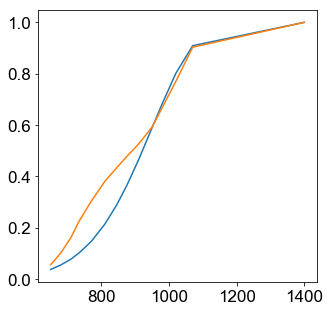

In [359]:
plt.figure(figsize = (5,5))
plt.plot(temp1, x1)
plt.plot(temp1, data_f)

# Age Spectra Model and Data

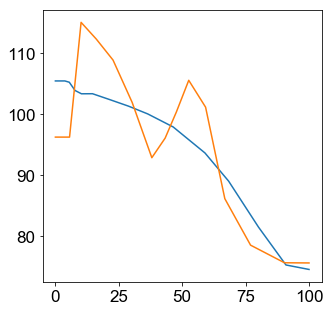

In [360]:
x1_plot = np.insert(x1, 0, 0)
x2_plot = np.insert(x2, 0, x2[0])
plt.figure(figsize = (5,5))
plt.plot(100*x1_plot, x2_plot)
plt.plot(y, age_plot)

In [361]:
low_age_plot = np.insert(low_age, 0, low_age[0])
high_age_plot = np.insert(high_age, 0, high_age[0])

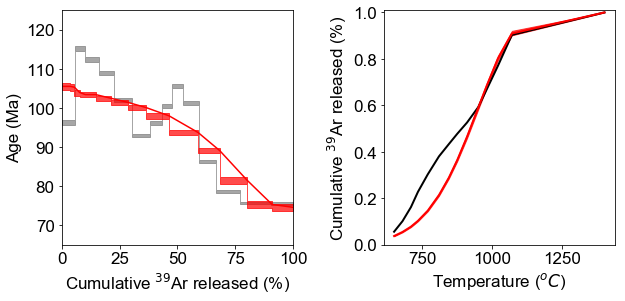

In [362]:
y = np.insert(x, 0, 0)
age_plot = np.insert(data, 0, data[0])
age_plot_err = np.insert(err, 0, err[0])


fig, ax = plt.subplots(1,2, figsize = (9, 4.5))
# Age
ax[0].fill_between(y, age_plot - age_plot_err, age_plot + age_plot_err, 
                  step = 'pre', 
                  color = 'grey', alpha = 0.7, 
                  edgecolor = 'k')
ax[0].set_xlim(y.min(), y.max())


ax[0].plot(100*x1_plot, x2_plot, 'r-')
ax[0].fill_between(100*x1_plot, low_age_plot, 
                   high_age_plot,
                  step = 'pre', 
                  color = 'r', alpha = 0.7, 
                  edgecolor = 'k')

ax[0].set_ylabel('Age (Ma)')
ax[0].set_xlabel('Cumulative $^{39}$Ar released (%)')

ax[0].set_ylim(65, 125)


# Cumulative Release

ax[1].plot(temp1,x/100, lw = 2, 
          color= 'k')
ax[1].plot(temp1,x1, lw = 2, 
          color= 'r')
ax[1].fill_between(temp1, low_f, 
                   high_f,
                  color = 'r', alpha = 0.7, 
                  edgecolor = 'k')
ax[1].set_ylabel('Cumulative $^{39}$Ar released (%)')
ax[1].set_xlabel('Temperature ($^{o}C$)')
ax[1].set_ylim(0, 1.01)
plt.tight_layout()

 # Print Ages

In [363]:
print(trace['age1'][-5000::2].mean(axis =0))
print(trace['age2'][-5000::2].mean(axis =0))


print(2*np.std(trace['age1'][-5000::2]))
print(2*np.std(trace['age2'][-5000::2]))

139.19256881270437
74.40526362658038
4.189656096165946
0.8781397170804061


# Posterior DataFrame

In [364]:
df = pd.DataFrame({"age_model": x2,
                   "age_model_low":low_age, 
                   "age_model_high":high_age, 
                   "frel_model": x1, 
                   "frel_model_low": low_f, 
                   "frel_model_high":high_f, 
                   "age_data": data, 
                   "age_err": err,
                   "frel_data":x/100, 
                   "temp":temp1
                  })

In [192]:
df.to_csv("Kula_biotite_3_posterior.csv")

In [171]:
df2 = pm.trace_to_dataframe(trace[-SAMPLES::5])
df2.to_csv("Kula_biotite_3_trace.csv")